In [1]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD, NamedArrays
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/20/dynein/run"
rtdos = "/home/pbarletta/labo/20/dynein/rtdos_log"

"/home/pbarletta/labo/20/dynein/rtdos_log"

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [2]:
pdb = "3zke"
# Leo modos
modes_zke, evals_zke = JUMD.readPtrajModes(joinpath(home, pdb,  "pca", string("modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_zke))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", "vol_ecf_trj_het"))[:, 3]);
trj_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", "vol_edf_trj_het"))[:, 3]);

# Leo volúmenes originales
vol_avg_ecf = convert(Float64, readdlm(joinpath(home, pdb,  "cavidad", "vol_ecf_het"))[2])
vol_avg_edf = convert(Float64, readdlm(joinpath(home, pdb,  "cavidad", "vol_edf_het"))[2])

204.332

## Volumen de la trayectoria

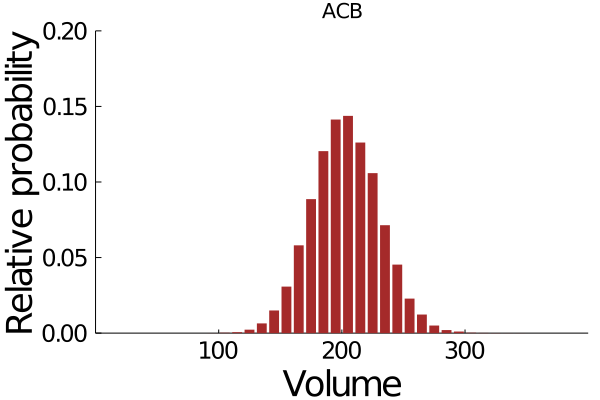

In [11]:
st = 10
max_vol = 400
bin_vol = collect(0:st:max_vol)
wgh_vol = fill(1.0, length(trj_vol_ecf))

# Histograma ponderado
Wbins_vol_ecf, Whis_vol_ecf = JUMD.weightedHist(trj_vol_ecf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_ecf, Whis_vol_ecf,
    xlims = (0, max_vol), ylims = (0, .2),
    xticks = 100:100:max_vol-50,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ACB", yaxis = "Relative probability", xaxis = "Volume")

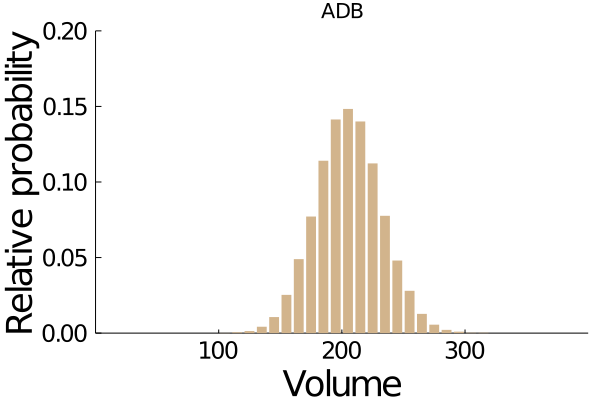

In [12]:
# Histograma ponderado
Wbins_vol_edf, Whis_vol_edf = JUMD.weightedHist(trj_vol_edf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_edf, Whis_vol_edf,
    xlims = (0, max_vol), ylims = (0, .2),
    xticks = 100:100:max_vol-50,
    linecolor = false, fillcolor = Colors.colorant"Tan",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ADB", yaxis = "Relative probability", xaxis = "Volume")

In [14]:
NamedArray([ mean(trj_vol_ecf) std(trj_vol_ecf) std(trj_vol_ecf) / mean(trj_vol_ecf) ; 
     mean(trj_vol_edf) std(trj_vol_edf) std(trj_vol_edf) / mean(trj_vol_edf) ],
    (["ACB" ; "ADB"], ["μ" ; "std" ; "μ/std"]))

2×3 Named Array{Float64,2}
A ╲ B │        μ       std     μ/std
──────┼─────────────────────────────
ACB   │  202.907   27.4369  0.135219
ADB   │  205.459   26.6782  0.129847

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [4]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_zke = Array{Float64, 1}(undef, nframes)
prj_2_zke = Array{Float64, 1}(undef, nframes)
prj_3_zke = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_zke[i] = dot(norm_dif[:, i], modes_zke[:, 1])
    prj_2_zke[i] = dot(norm_dif[:, i], modes_zke[:, 2])
    prj_3_zke[i] = dot(norm_dif[:, i], modes_zke[:, 3])
end

# Smooth
smooth_prj_1_zke = [ mean(prj_1_zke[i:i+9]) for i = 1:10:length(prj_1_zke)-9 ]
smooth_prj_2_zke = [ mean(prj_2_zke[i:i+9]) for i = 1:10:length(prj_2_zke)-9 ]
smooth_prj_3_zke = [ mean(prj_3_zke[i:i+9]) for i = 1:10:length(prj_3_zke)-9 ];

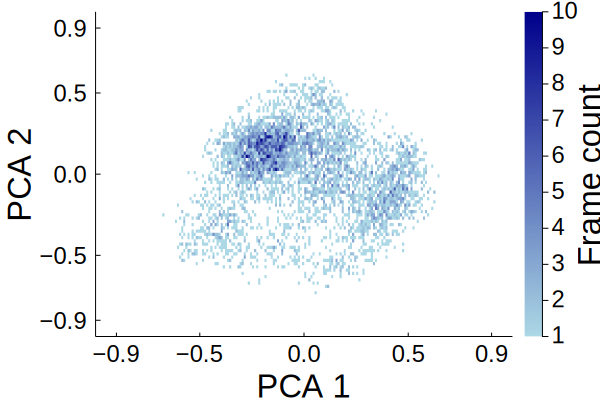

In [5]:
plt_2his = histogram2d(smooth_prj_1_zke, smooth_prj_2_zke, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)

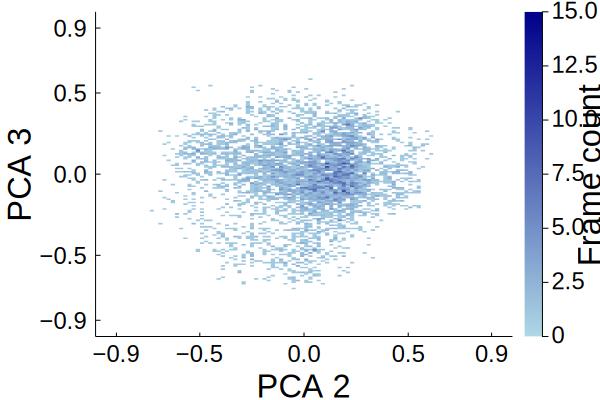

In [6]:
plt_2his = histogram2d(smooth_prj_2_zke, smooth_prj_3_zke, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 3", xaxis = "PCA 2",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)

### Defino los frames a partir de los cuales saco 4 réplicas

In [7]:
pca1_min = findmin(prj_1_zke)
pca1_max = findmax(prj_1_zke)
pca2_min = findmin(prj_2_zke)
pca2_max = findmax(prj_2_zke)

NamedArray( [ pca1_min pca1_max ; pca2_min pca2_max ],
    (["PCA 1" ; "PCA 2"], ["MIN" ; "MAX"]))

2×2 Named Array{Tuple{Float64,Int64},2}
A ╲ B │                MIN                 MAX
──────┼───────────────────────────────────────
PCA 1 │ (-0.729872, 29290)    (0.729245, 7680)
PCA 2 │  (-0.779845, 6090)   (0.717631, 45917)

In [8]:
nbr_of_trj = 5
frms_per_trj = convert(Int64, length(prj_1_zke) / nbr_of_trj)

NamedArray( [
    convert(Int64, 1 + floor(pca2_max[2] / frms_per_trj)) convert(Int64, pca2_max[2] % frms_per_trj) ;
    
    convert(Int64, 1 + floor(pca1_max[2] / frms_per_trj)) convert(Int64, pca1_max[2] % frms_per_trj) ;
    
    convert(Int64, 1 + floor(pca2_min[2] / frms_per_trj)) convert(Int64, pca2_min[2] % frms_per_trj) ;
        
    convert(Int64, 1 + floor(pca1_min[2] / frms_per_trj)) convert(Int64, pca1_min[2] % frms_per_trj) ],

    (["1 (PCA2MAX)" ; "2 (PCA1MAX)" ; "3 (PCA2MIN)" ; "4 (PCA1MIN)"], ["Traj" ; "Frame"]))

4×2 Named Array{Int64,2}
      A ╲ B │  Traj  Frame
────────────┼─────────────
1 (PCA2MAX) │     5   5917
2 (PCA1MAX) │     1   7680
3 (PCA2MIN) │     1   6090
4 (PCA1MIN) │     3   9290

### Cosas de Pnumbers de Marcos

## Junto con las 4 réplicas

In [3]:
# Leo volumen de la traj
trj_1_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "1_cavidad", "1_vol_ecf_trj_het"))[:, 3]);
trj_1_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "1_cavidad", "1_vol_edf_trj_het"))[:, 3]);

# Leo volumen de la traj
trj_2_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "2_cavidad", "2_vol_ecf_trj_het"))[:, 3]);
trj_2_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "2_cavidad", "2_vol_edf_trj_het"))[:, 3]);

# Leo volumen de la traj
trj_3_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_ecf_trj_het"))[:, 3]);
trj_3_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_edf_trj_het"))[:, 3]);

# Leo volumen de la traj
trj_4_vol_ecf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_ecf_trj_het"))[:, 3]);
trj_4_vol_edf = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_edf_trj_het"))[:, 3]);

In [4]:
vol_ecf = [ trj_vol_ecf ; trj_1_vol_ecf ; trj_2_vol_ecf ; trj_3_vol_ecf ; trj_4_vol_ecf ]
vol_edf = [ trj_vol_edf ; trj_1_vol_edf ; trj_2_vol_edf ; trj_3_vol_edf ; trj_4_vol_edf ];

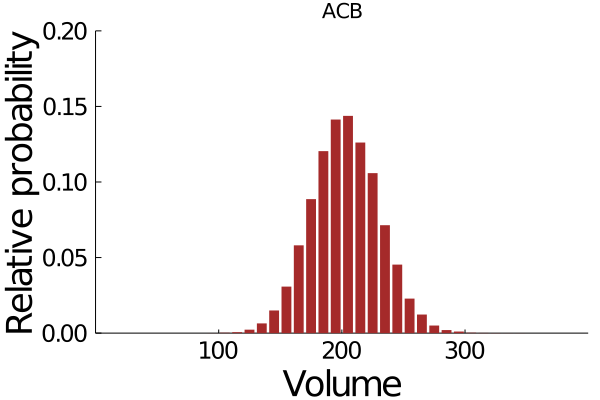

In [5]:
st = 10
max_vol = 400
bin_vol = collect(0:st:max_vol)
wgh_vol = fill(1.0, length(trj_vol_ecf))

# Histograma ponderado
Wbins_vol_ecf, Whis_vol_ecf = JUMD.weightedHist(trj_vol_ecf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_ecf, Whis_vol_ecf,
    xlims = (0, max_vol), ylims = (0, .2),
    xticks = 100:100:max_vol-50,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ACB", yaxis = "Relative probability", xaxis = "Volume")

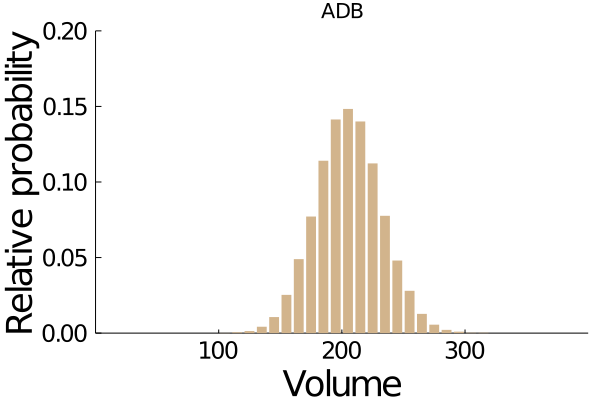

In [6]:
# Histograma ponderado
Wbins_vol_edf, Whis_vol_edf = JUMD.weightedHist(trj_vol_edf, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_edf, Whis_vol_edf,
    xlims = (0, max_vol), ylims = (0, .2),
    xticks = 100:100:max_vol-50,
    linecolor = false, fillcolor = Colors.colorant"Tan",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ADB", yaxis = "Relative probability", xaxis = "Volume")

In [7]:
NamedArray([ mean(trj_vol_ecf) std(trj_vol_ecf) std(trj_vol_ecf) / mean(trj_vol_ecf) ; 
     mean(trj_vol_edf) std(trj_vol_edf) std(trj_vol_edf) / mean(trj_vol_edf) ],
    (["ACB" ; "ADB"], ["μ" ; "std" ; "μ/std"]))

2×3 Named Array{Float64,2}
A ╲ B │        μ       std     μ/std
──────┼─────────────────────────────
ACB   │  202.907   27.4369  0.135219
ADB   │  205.459   26.6782  0.129847